# AE Structural Optimization Final Project: topology optimization
## Author: Donglai Yang

Objective: 
Finite-difference:      -466.81511 Answer:      -466.81606 Relative err:   2.0465517e-06
Constraint 0
Finite-difference:       5.0553537 Answer:       5.0553536 Relative err:  -7.9033983e-09


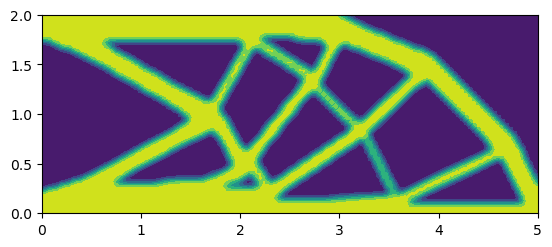

In [ ]:
import numpy as np
from scipy import sparse
from scipy import spatial
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.optimize import minimize
import matplotlib.pylab as plt
import matplotlib.tri as tri

def eval_shape_funcs(eta, xi):
    """
    Evaluate the shape functions and their derivatives
    """

    N = 0.25 * np.array(
        [
            (1.0 - xi) * (1.0 - eta),
            (1.0 + xi) * (1.0 - eta),
            (1.0 + xi) * (1.0 + eta),
            (1.0 - xi) * (1.0 + eta),
        ]
    )
    Nxi = 0.25 * np.array([-(1.0 - eta), (1.0 - eta), (1.0 + eta), -(1.0 + eta)])
    Neta = 0.25 * np.array([-(1.0 - xi), -(1.0 + xi), (1.0 + xi), (1.0 - xi)])

    return N, Nxi, Neta


def eval_shape_funcs_gradient(xi, eta, xe, ye):
    """
    Evaluate the derivative of the shape functions in the physical
    coordinate system by applying the Jacobian transformation
    """

    N, Nxi, Neta = eval_shape_funcs(eta, xi)

    # Store the Jacobian and the inverse of the Jacobian
    nelems = xe.shape[0]
    J = np.zeros((nelems, 2, 2))
    invJ = np.zeros(J.shape)

    # Compute the Jacobian transformation at each quadrature points
    J[:, 0, 0] = np.dot(xe, Nxi)
    J[:, 1, 0] = np.dot(ye, Nxi)
    J[:, 0, 1] = np.dot(xe, Neta)
    J[:, 1, 1] = np.dot(ye, Neta)

    # Compute the inverse of the Jacobian
    detJ = J[:, 0, 0] * J[:, 1, 1] - J[:, 0, 1] * J[:, 1, 0]
    invJ[:, 0, 0] = J[:, 1, 1] / detJ
    invJ[:, 0, 1] = -J[:, 0, 1] / detJ
    invJ[:, 1, 0] = -J[:, 1, 0] / detJ
    invJ[:, 1, 1] = J[:, 0, 0] / detJ

    # Compute the derivative of the shape functions w.r.t. xi and eta
    # [Nx, Ny] = [Nxi, Neta]*invJ
    Nx = np.outer(invJ[:, 0, 0], Nxi) + np.outer(invJ[:, 1, 0], Neta)
    Ny = np.outer(invJ[:, 0, 1], Nxi) + np.outer(invJ[:, 1, 1], Neta)

    return detJ, Nx, Ny


class NodeFilter:
    """
    A node-based filter for topology optimization
    """

    def __init__(
        self, conn, X, r0=1.0, ftype="spatial", beta=10.0, eta=0.5, projection=False
    ):
        """
        Create a filter
        """
        self.conn = np.array(conn)
        self.X = np.array(X)
        self.nelems = self.conn.shape[0]
        self.nnodes = int(np.max(self.conn)) + 1

        # Store information about the projection
        self.beta = beta
        self.eta = eta
        self.projection = projection

        # Store information about the filter
        self.F = None
        self.A = None
        self.B = None
        if ftype == "spatial":
            self._initialize_spatial(r0)
        else:
            self._initialize_helmholtz(r0)

        return

    def _initialize_spatial(self, r0):
        """
        Initialize the spatial filter
        """

        # Create a KD tree
        tree = spatial.KDTree(self.X)

        F = sparse.lil_matrix((self.nnodes, self.nnodes))
        for i in range(self.nnodes):
            indices = tree.query_ball_point(self.X[i, :], r0)
            Fhat = np.zeros(len(indices))

            for j, index in enumerate(indices):
                dist = np.sqrt(
                    np.dot(
                        self.X[i, :] - self.X[index, :], self.X[i, :] - self.X[index, :]
                    )
                )
                Fhat[j] = r0 - dist

            Fhat = Fhat / np.sum(Fhat)
            F[i, indices] = Fhat

        self.F = F.tocsr()
        self.FT = self.F.transpose()

        return

    def _initialize_helmholtz(self, r0):
        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.conn[index, :]:
                for jj in self.conn[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        i_index = np.array(i, dtype=int)
        j_index = np.array(j, dtype=int)

        # Quadrature points
        gauss_pts = [-1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0)]

        # Assemble all of the the 4 x 4 element stiffness matrices
        Ae = np.zeros((self.nelems, 4, 4))
        Ce = np.zeros((self.nelems, 4, 4))

        Be = np.zeros((self.nelems, 2, 4))
        He = np.zeros((self.nelems, 1, 4))

        # Compute the x and y coordinates of each element
        xe = self.X[self.conn, 0]
        ye = self.X[self.conn, 1]

        for j in range(2):
            for i in range(2):
                xi = gauss_pts[i]
                eta = gauss_pts[j]
                # Evaluate the gradient of the shape functions in physical coordinates
                N, Nxi, Neta = eval_shape_funcs(xi, eta)
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, xe, ye)

                # Set the B matrix for each element
                He[:, 0, :] = N
                Be[:, 0, :] = Nx
                Be[:, 1, :] = Ny

                Ce += np.einsum("n,nij,nil -> njl", detJ, He, He)
                Ae += np.einsum("n,nij,nil -> njl", detJ * r0**2, Be, Be)

        # Finish the computation of the Ae matrices
        Ae += Ce

        A = sparse.coo_matrix((Ae.flatten(), (i_index, j_index)))
        A = A.tocsc()
        self.A = linalg.factorized(A)

        B = sparse.coo_matrix((Ce.flatten(), (i_index, j_index)))
        self.B = B.tocsr()
        self.BT = self.B.transpose()

        return

    def apply_filter(self, x):
        if self.F is not None:
            rho = self.F @ x
        else:
            rho = self.A(self.B.dot(x))

        if self.projection:
            denom = np.tanh(self.beta * self.eta) + np.tanh(
                self.beta * (1.0 - self.eta)
            )
            rho = (
                np.tanh(self.beta * self.eta) + np.tanh(self.beta * (rho - self.eta))
            ) / denom

        return rho

    def apply_filter_gradient(self, g, x=None):
        if self.projection:
            if self.F is not None:
                rho = self.F @ x
            else:
                rho = self.A(self.B.dot(x))

            denom = np.tanh(self.beta * self.eta) + np.tanh(
                self.beta * (1.0 - self.eta)
            )
            grad = (
                (self.beta / denom) * 1.0 / np.cosh(self.beta * (rho - self.eta)) ** 2
            ) * g
        else:
            grad = g

        if self.F is not None:
            return self.FT @ grad
        else:
            return self.BT.dot(self.A(grad))

    def plot(self, u, ax=None, **kwargs):
        """
        Create a plot
        """

        # Create the triangles
        triangles = np.zeros((2 * self.nelems, 3), dtype=int)
        triangles[: self.nelems, 0] = self.conn[:, 0]
        triangles[: self.nelems, 1] = self.conn[:, 1]
        triangles[: self.nelems, 2] = self.conn[:, 2]

        triangles[self.nelems :, 0] = self.conn[:, 0]
        triangles[self.nelems :, 1] = self.conn[:, 2]
        triangles[self.nelems :, 2] = self.conn[:, 3]

        # Create the triangulation object
        tri_obj = tri.Triangulation(self.X[:, 0], self.X[:, 1], triangles)

        if ax is None:
            fig, ax = plt.subplots()

        # Set the aspect ratio equal
        ax.set_aspect("equal")

        # Create the contour plot
        ax.tricontourf(tri_obj, u, **kwargs)

        return


class PlaneStress:
    def __init__(
        self, conn, X, bcs, forces={}, E=10.0, nu=0.3, rho=1.0, p=3.0, fltr=None
    ):
        self.conn = np.array(conn)
        self.X = np.array(X)

        self.nelems = self.conn.shape[0]
        self.nnodes = int(np.max(self.conn)) + 1
        self.nvars = 2 * self.nnodes

        # Compute the constitutivve matrix
        self.C = E * np.array(
            [[1.0, nu, 0.0], [nu, 1.0, 0.0], [0.0, 0.0, 0.5 * (1.0 - nu)]]
        )
        self.C *= 1.0 / (1.0 - nu**2)
        self.rho = rho
        self.p = p

        # Set the filter
        self.fltr = fltr

        self.reduced = self._compute_reduced_variables(self.nvars, bcs)
        self.f = self._compute_forces(self.nvars, forces)

        # Compute the x and y coordinates of each element
        self.xe = self.X[self.conn, 0]
        self.ye = self.X[self.conn, 1]

        # Set the quadrature points
        self.gauss_pts = [-1.0 / np.sqrt(3.0), 1.0 / np.sqrt(3.0)]

        # Set up the i-j indices for the matrix - these are the row
        # and column indices in the stiffness matrix
        self.var = np.zeros((self.conn.shape[0], 8), dtype=int)
        self.var[:, ::2] = 2 * self.conn
        self.var[:, 1::2] = 2 * self.conn + 1

        i = []
        j = []
        for index in range(self.nelems):
            for ii in self.var[index, :]:
                for jj in self.var[index, :]:
                    i.append(ii)
                    j.append(jj)

        # Convert the lists into numpy arrays
        self.i = np.array(i, dtype=int)
        self.j = np.array(j, dtype=int)

    def _compute_reduced_variables(self, nvars, bcs):
        """
        Compute the reduced set of variables
        """
        reduced = list(range(nvars))

        # For each node that is in the boundary condition dictionary
        for node in bcs:
            uv_list = bcs[node]

            # For each index in the boundary conditions (corresponding to
            # either a constraint on u and/or constraint on v
            for index in uv_list:
                var = 2 * node + index
                reduced.remove(var)

        return reduced

    def _compute_forces(self, nvars, forces):
        """
        Unpack the dictionary containing the forces
        """
        f = np.zeros(nvars)

        for node in forces:
            f[2 * node] += forces[node][0]
            f[2 * node + 1] += forces[node][1]

        return f

    def assemble_stiffness_matrix(self, rhoE):
        """
        Assemble the stiffness matrix
        """

        # Assemble all of the the 8 x 8 element stiffness matrix
        Ke = np.zeros((self.nelems, 8, 8))
        Be = np.zeros((self.nelems, 3, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the B matrix for each element
                Be[:, 0, ::2] = Nx
                Be[:, 1, 1::2] = Ny
                Be[:, 2, ::2] = Ny
                Be[:, 2, 1::2] = Nx

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * (rhoE**self.p)
                Ke += np.einsum("n,nij,ik,nkl -> njl", scale, Be, self.C, Be)

                # This is a slower way to compute the element matrices
                # for k in range(self.nelems):
                #     Ke[k, :, :] += detJ[k]*np.dot(Be[k, :, :].T, np.dot(self.C, Be[k, :, :]))

        K = sparse.coo_matrix((Ke.flatten(), (self.i, self.j)))
        K = K.tocsr()

        return K

    def assemble_mass_matrix(self, rhoE):
        """
        Assemble the mass matrix for plane stress problem
        """

        # Compute the element stiffness matrix
        gauss_pts = [-1.0/np.sqrt(3.0), 1.0/np.sqrt(3.0)]

        # Assemble all of the the 8 x 8 element mass matrices
        Me = np.zeros((self.nelems, 8, 8))
        He = np.zeros((self.nelems, 2, 8))

        # Compute the x and y coordinates of each element
        xe = self.x[self.conn, 0]
        ye = self.x[self.conn, 1]

        for j in range(2):
            for i in range(2):
                xi = gauss_pts[i]
                eta = gauss_pts[j]

                # Evaluate the shape functions
                N, _, _ = self._eval_shape_funcs(xi, eta)

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = self._eval_shape_gradient(xi, eta, xe, ye)

                # Set the B matrix for each element
                He[:, 0, ::2] = N
                He[:, 1, 1::2] = N

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * (rhoE**self.p)
                Me += self.rho*np.einsum('n,nij,nil -> njl', scale, He, He)

                # This is a slower way to compute the element matrices
                # for k in range(self.nelems):
                #     Me[k, :, :] += self.rho*detJ[k]*np.dot(He[k, :, :].T, He[k, :, :])

        M = sparse.coo_matrix((Me.flatten(), (self.i, self.j)))
        M = M.tocsr()

        return M

    def stiffness_matrix_derivative(self, rhoE, u, v):
        """
        Compute u^{T}*dK/drhoE*v

        This is provided at the end of 'topology optimization' lecture notes
        """

        # Set the derivative we're about to compute
        dfdrhoE = np.zeros(self.nelems)

        # Assemble all of the the 8 x 8 element stiffness matrix
        Be = np.zeros((self.nelems, 3, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the B matrix for each element
                Be[:, 0, ::2] = Nx
                Be[:, 1, 1::2] = Ny
                Be[:, 2, ::2] = Ny
                Be[:, 2, 1::2] = Nx

                eps_u = np.einsum("nij,nj -> ni", Be, u[self.var])
                eps_v = np.einsum("nij,nj -> ni", Be, v[self.var])

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * self.p * rhoE ** (self.p - 1.0)
                dfdrhoE += np.einsum("n,ni,ij,nj -> n", scale, eps_u, self.C, eps_v)

        return dfdrhoE
    
    def mass_matrix_derivative(self, v):
        """
        Compute dm/drhoE
        """

        # Set the derivative we're about to compute
        dmdrhoE = np.zeros(self.nelems)

        # Assemble all of the the 8 x 8 element mass matrix
        He = np.zeros((self.nelems, 2, 8))

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Set the H matrix for each element
                He[:, 0, ::2] = Nx
                He[:, 1, 1::2] = Ny

                vel_v = np.einsum("nij,nj -> ni", He, v[self.var])

                # This is a fancy (and fast) way to compute the element matrices
                scale = detJ * self.p * self.rho * (self.rhoE ** (self.p - 1.0))
                dmdrhoE += np.einsum("n,ni,ni -> n", scale, vel_v, vel_v)

        return dmdrhoE
    
    def frequencies(self, A, k=5, sigma=0.0):
        """
        Compute the k-th smallest natural frequencies
        """

        self.rhoE = self._compute_rhoE(A)
        K = self.assemble_stiffness_matrix(self.rhoE)
        Kr = self.reduce_matrix(K)

        M = self.assemble_mass_matrix(self.rhoE)
        Mr = self.reduce_matrix(M)

        # Find the eigenvalues closest to zero. This uses a shift and
        # invert strategy around sigma = 0, which means that the largest
        # magnitude values are closest to zero.
        if k < len(self.reduced):
            eigs, phir = sparse.linalg.eigsh(Kr, M=Mr, k=k, sigma=sigma,
                                             which='LM', tol=1e-6)
        else:
            eigs, phir = scipy.linalg.eigh(Kr.todense(), b=Mr.todense())
            k = len(eigs)

        phi = np.zeros((self.nvars, k))
        for i in range(k):
            phi[self.reduced, i] = phir[:, i]

        return np.sqrt(eigs), phi

    def frequency_derivative(self, A, k=5):
        """
        Compute the gradient of the smallest eigenvalues, assuming they are unique
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        omega, phi = self.frequencies(A, k=k)

        omega_grad = []
        for i in range(k):
            kx = self.compute_stiffness_matrix_derivative(phi[:, i])
            mx = self.compute_mass_matrix_derivative(phi[:, i])
            grad = kx - mx*omega[i]**2
            omega_grad.append((0.5/omega[i])*grad)

        return omega_grad

    def ks_min_eigenvalue(self, A, ks_rho=100.0, k=5):
        """
        Compute the ks minimum eigenvalue
        """
        if k > len(self.reduced):
            k = len(self.reduced)

        self.rhoE = self._compute_rhoE(A)
        omega, phi = self.frequencies(A, k=k)
        lamb = omega**2

        c = np.min(lamb)
        eta = np.exp(-ks_rho*(lamb - c))
        a = np.sum(eta)
        ks_min = c - np.log(a)/ks_rho
        eta *= 1.0/a

        ks_grad = np.zeros(self.nelems)
        for i in range(k):
            kx = self.compute_stiffness_matrix_derivative(phi[:, i])
            mx = self.compute_mass_matrix_derivative(phi[:, i])
            ks_grad += eta[i]*(kx - mx*lamb[i])

        return ks_min, ks_grad

    def reduce_vector(self, forces):
        """
        Eliminate essential boundary conditions from the vector
        """
        return forces[self.reduced]

    def reduce_matrix(self, matrix):
        """
        Eliminate essential boundary conditions from the matrix
        """
        temp = matrix[self.reduced, :]
        return temp[:, self.reduced]

    def _compute_rhoE(self, x):
        # Apply the spatial/PDE filter
        rho = self.fltr.apply(x)

        # Compute the element-based density values
        rhoE = 0.25 * (
            rho[self.conn[:, 0]]
            + rho[self.conn[:, 1]]
            + rho[self.conn[:, 2]]
            + rho[self.conn[:, 3]]
        )

        return rhoE

    def _compute_rhoE_gradient(self, x, dfdrhoE):

        # Add derivative contributions from the four nodes. np.add.at is used
        # because the connectivity array may contain duplicate indices, so regular
        # adding will not work.
        dfdrho = np.zeros((self.nnodes))
        contrib = 0.25 * dfdrhoE
        for k in range(4):
            np.add.at(dfdrho, self.conn[:, k], contrib)

        # Compute the derivative
        return self.fltr.apply_gradient(dfdrho, x=x)

    def compliance(self, x):
        """
        Given the design variables x, find the compliance
        """

        # Compute the element-based density values
        self.rhoE = self._compute_rhoE(x)

        # Form and solve the governing equations
        K = self.assemble_stiffness_matrix(self.rhoE)
        Kr = self.reduce_matrix(K)
        fr = self.reduce_vector(self.f)

        ur = sparse.linalg.spsolve(Kr, fr)

        # Save the solution vector for later
        self.u = np.zeros(self.nvars)
        self.u[self.reduced] = ur

        return ur.dot(fr)

    def compliance_gradient(self, x):
        """
        Compute the gradient of the compliance. Assume that the displacements have already been computed.
        """

        # Compute the derivative of the compliance
        dfdrhoE = -self.stiffness_matrix_derivative(self.rhoE, self.u, self.u)

        return self._compute_rhoE_gradient(x, dfdrhoE)

    def compute_area(self, x):
        """Compute the area/volume of the structure"""

        self.rhoE = self._compute_rhoE(x)

        area = 0.0
        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Add the contributions to the area
                area += np.dot(detJ, self.rhoE)

        return area

    def compute_area_gradient(self, x):
        """
        This assumes that the mass is a function of"""

        # The derivative of the mass w.r.t. rhoE
        dAdrhoE = np.zeros(self.nelems)

        for j in range(2):
            for i in range(2):
                xi = self.gauss_pts[i]
                eta = self.gauss_pts[j]

                # Evaluate the gradient of the shape functions in physical coordinates
                detJ, Nx, Ny = eval_shape_funcs_gradient(xi, eta, self.xe, self.ye)

                # Assuming rhoE is contant for each element
                dAdrhoE[:] += detJ

        return self._compute_rhoE_gradient(x, dAdrhoE)


class MassConstrainedCompliance:
    def __init__(self, ps, area_fixed):
        self.ps = ps
        self.area_fixed = area_fixed

    def obj_con(self, x):
        fobj = self.ps.compliance(x)
        con = np.array([self.ps.compute_area(x) - self.area_fixed])  # <= 0.0

        return fobj, con

    def obj_con_grad(self, x):
        fgrad = self.ps.compliance_gradient(x)
        # Up-convert to a 1 x nnodes numpy array
        A = self.ps.compute_area_gradient(x)[np.newaxis, :]

        return fgrad, A

    def _get_string(self, fd, ans, err):
        s = f"Finite-difference: {fd:15.8} Answer: {ans:15.8} Relative err: {err:15.8}"
        return s

    def check_gradient(self, x, p=None, dh=1e-6):
        """Perform a finite-difference check along the direction p"""

        if p is None:
            p = np.random.uniform(size=x.shape)

        fobj, con = self.obj_con(x)
        fgrad, A = self.obj_con_grad(x)

        fobj1, con1 = self.obj_con(x + dh * p)

        fd = (fobj1 - fobj) / dh
        ans = np.dot(fgrad, p)
        rel_err = (ans - fd) / fd
        print("Objective: ")
        print(self._get_string(fd, ans, rel_err))

        for i in range(len(con)):
            fd = (con1[i] - con[i]) / dh
            ans = np.dot(A[i, :], p)
            rel_err = (ans - fd) / fd
            print(f"Constraint {i}")
            print(self._get_string(fd, ans, rel_err))


class MMA:
    def __init__(self, n, m, x_init, lb, ub, objfunc, gradfunc):

        self.n = n
        self.m = m

        self.lb = lb
        self.ub = ub
        self.objfunc = objfunc
        self.gradfunc = gradfunc

        self.mma_iter = 0

        # Allocate space for the design variables
        self.x = np.zeros(self.n)
        self.x1 = np.zeros(self.n)
        self.x2 = np.zeros(self.n)

        # Set the initial design point
        self.x[:] = x_init[:]

        # The objective and constraint functions
        self.c = np.zeros(self.m)
        self.g = np.zeros(self.n)
        self.A = np.zeros((self.m, self.n))

        self.b = np.zeros(self.m)
        self.L = np.zeros(self.n)
        self.U = np.zeros(self.n)
        self.alpha = np.zeros(self.n)
        self.beta = np.zeros(self.n)

        self.p = np.zeros((self.m + 1, self.n))
        self.q = np.zeros((self.m + 1, self.n))

        # Set the optimization parameters
        self.move_limit = 0.5
        self.init_asymptote_offset = 0.1
        self.asymptote_relax = 1.2
        self.asymptote_contract = 0.7
        self.min_asymptote_offset = 1e-3
        self.max_asymptote_offset = 10.0
        self.eps_regularization = 0.0  # 1e-5
        self.delta_regularization = 0.0  # 1e-3

    def update_asymptotes(self):
        lower = np.maximum(self.lb, self.x - self.move_limit)
        upper = np.minimum(self.ub, self.x + self.move_limit)
        diff = upper - lower

        if self.mma_iter < 2:
            self.L = self.x - self.init_asymptote_offset * diff
            self.U = self.x + self.init_asymptote_offset * diff
        else:
            # Compute the product of the difference of the two previous
            # updates to determine how to update the move limits. If the
            # signs are different, then indc < 0.0 and we contract the
            # asymptotes, otherwise we expand the asymptotes.
            indc = (self.x - self.x1) * (self.x1 - self.x2)

            # Compute the interval length
            intrvl = np.maximum(diff, 0.01)
            intrvl = np.minimum(intrvl, 100.0)

            # Select contraction or relaxation factors per index
            mask = indc < 0.0
            scale = np.where(mask, self.asymptote_contract, self.asymptote_relax)

            # Update the asymtotes
            self.L = self.x - scale * (self.x1 - self.L)
            self.U = self.x + scale * (self.U - self.x1)

            # Ensure that the asymptotes do not converge entirely on the design
            # variable value
            self.L = np.minimum(self.L, self.x - self.min_asymptote_offset * intrvl)
            self.U = np.maximum(self.U, self.x + self.min_asymptote_offset * intrvl)

            # Enforce a maximum offset so that the asymptotes do not move too far
            # away from the design variables
            self.L = np.maximum(self.L, self.x - self.max_asymptote_offset * intrvl)
            self.U = np.minimum(self.U, self.x + self.max_asymptote_offset * intrvl)

        # Compute the differences
        Ux = self.U - self.x
        xL = self.x - self.L

        # Compute the lower and upper bounds
        self.alpha = np.maximum(lower, 0.9 * self.L + 0.1 * self.x, self.x - 0.5 * diff)
        self.beta = np.minimum(upper, 0.9 * self.U + 0.1 * self.x, self.x + 0.5 * diff)

        # Compute the MMA coefficients for the objective
        eps = self.eps_regularization
        delta = self.delta_regularization
        gpos = np.maximum(self.g, 0.0)
        gneg = np.maximum(-self.g, 0.0)
        gpos_reg = (1.0 + delta) * gpos + delta * gneg + eps / (self.U - self.L)
        gneg_reg = (1.0 + delta) * gneg + delta * gpos + eps / (self.U - self.L)

        # Update p and q for the objective
        self.p[0, :] = gpos_reg * Ux**2
        self.q[0, :] = gneg_reg * xL**2

        # Update p and q for the constraints
        gpos = np.maximum(self.A, 0.0)
        gneg = np.maximum(-self.A, 0.0)
        self.p[1:, :] = gpos * Ux**2
        self.q[1:, :] = gneg * xL**2

        # Compute the b right-hand-side for the constraints
        self.b[:] = -self.c
        self.b[:] += np.sum(self.p[1:, :] / Ux, axis=1)
        self.b[:] += np.sum(self.q[1:, :] / xL, axis=1)

        return

    def compute_design_from_dual(self, y):
        """Compute the design variables from the dual variables"""

        # Convenience variable y0 = [1.0, y[0], y[1], ..., y[m-1]]
        y0 = np.ones(self.m + 1)
        y0[1:] = y[:]

        # Compute the design variables as a function of the dual variables x(y)
        a = np.sqrt(self.p.T @ y0)
        b = np.sqrt(self.q.T @ y0)

        return np.clip((a * self.L + b * self.U) / (a + b), self.alpha, self.beta)

    def dual_objective(self, y):
        x0 = self.compute_design_from_dual(y)

        y0 = np.ones(self.m + 1)
        y0[1:] = y[:]

        # Compute the dual objective function
        Ux = self.U - x0
        xL = x0 - self.L
        obj = np.sum((self.p.T @ y0) / Ux + (self.q.T @ y0) / xL) - np.dot(y, self.b)

        # Return the negative of the dual objective since we want
        # to maximize the objective function
        return -1.0 * obj

    def dual_gradient(self, y):
        x0 = self.compute_design_from_dual(y)

        # Initialize the gradient
        g = np.zeros(self.m)
        g[:] = -self.b

        Ux = self.U - x0
        xL = x0 - self.L
        g[:] += np.sum(self.p[1:, :] / Ux[np.newaxis, :], axis=1)
        g[:] += np.sum(self.q[1:, :] / xL[np.newaxis, :], axis=1)

        return -g

    def solve_dual_problem(self):

        # Define the initial point
        y_init = np.ones(self.m)

        # Define bounds: x >= 0
        bounds = [(0, None)] * self.m

        # Run optimization
        res = minimize(
            self.dual_objective,
            y_init,
            bounds=bounds,
            method="L-BFGS-B",
        )

        if not res.success:
            print("MMA subproblem optimization failed")
            return np.zeros(self.m)

        return res.x

    def update(self):
        fobj, con = self.objfunc(self.x)
        self.c[:] = con[:]

        grad, jac = self.gradfunc(self.x)
        self.g[:] = grad[:]
        self.A[:] = jac

        # Update the asymptotes
        self.update_asymptotes()

        # Solve the dual subproblem
        y = self.solve_dual_problem()

        # Update the design variables
        self.x2[:] = self.x1[:]
        self.x1[:] = self.x[:]
        self.x[:] = self.compute_design_from_dual(y)

        self.mma_iter += 1

        return

# Set the dimensions of the design domain
Lx = 5.0
Ly = 2.0
nx = 125
ny = 50

# Set the filter radius
r0 = 2 * (Lx / nx)

# Set the number of elements and nodes
nelems = nx * ny
nnodes = (nx + 1) * (ny + 1)

# Set locations x/y locations along each edge and node numbers
x = np.linspace(0, Lx, nx + 1)
y = np.linspace(0, Ly, ny + 1)
nodes = np.arange(0, (nx + 1) * (ny + 1)).reshape((nx + 1, ny + 1))

# Set the node locations
X = np.zeros((nnodes, 2))
for j in range(ny + 1):
    for i in range(nx + 1):
        X[nodes[i, j], 0] = x[i]
        X[nodes[i, j], 1] = y[j]

# Set the connectivity
conn = np.zeros((nelems, 4), dtype=int)
for j in range(ny):
    for i in range(nx):
        conn[i + j * nx, 0] = nodes[i, j]
        conn[i + j * nx, 1] = nodes[i + 1, j]
        conn[i + j * nx, 2] = nodes[i + 1, j + 1]
        conn[i + j * nx, 3] = nodes[i, j + 1]

# Set boundary conditions for the finite-element problem
bcs = {}
for j in range(ny):
    bcs[nodes[0, j]] = [0, 1]

# Set the load
P = 1.0
forces = {}
forces[nodes[-1, 0]] = [0, -P]

# Create a spatial filter
fltr = NodeFilter(conn, X, r0=r0, ftype="spatial")

# Create the plane stress problem
ps = PlaneStress(conn, X, bcs, forces, fltr=fltr)

# Create the optimization object
area_fraction = 0.4
opt = MassConstrainedCompliance(ps, area_fraction * Lx * Ly)

lb = 1e-3 * np.ones(nnodes)
ub = np.ones(nnodes)
x_init = area_fraction * np.ones(nnodes)

opt.check_gradient(x_init)

mma = MMA(nnodes, 1, x_init, lb, ub, opt.obj_con, opt.obj_con_grad)

for i in range(50):
    mma.update()

fltr.plot(fltr.apply(mma.x))
plt.show()